# Reservoir Computing with Genetic Oscillators
Here we will go through a full tutorial of using our genetic oscillator reservoir for classification and forecasting, as well as hyperparameter optimization.

## 1. Global Configuration


## 1.1 Ensuring Reproducibility
We must fix the random state of our system with a static seed to ensure reproducibility.

In [1]:
import numpy as np
import reservoirpy as rpy

# Define global seed for random state generators
SEED = 1337

# Set reservoirpy verbosity to 1 (enabled)
VERBOSITY = 0

# Fix our random state generators
rpy.set_seed(SEED)
np.random.seed(SEED)

# set reservoirpy verbosity to 0 (OFF)
rpy.verbosity(VERBOSITY)



0

### 1.1 Initializing the Logger
In `utils.logger` we have defined a custom `Logger` class which wraps the standard Python `logging` module to allow for parallel writes to stream and file whilst maintaing a single handler per type.

Our Logger is important in ensuring that we keep track of the hyperparameters and metrics of our model.

In [2]:
from utils.logger import Logger

# Set our logging level to 1 (DEBUG)
LOG_LEVEL = 1

# Initialize our logger with a log file
log_name = "reservoir-computing-tutorial"
log_file = f"logs/{log_name}.log"
logger = Logger(level=LOG_LEVEL, log_file=log_file)

## 2. Loading the Classification Dataset

We'll start by loading our ECG dataset using a function from our preprocessing module. This function allows us to specify various parameters:

- `rows`: Specifies the number of instances to load. To maintain class balance, it's capped at 4015.
- `test_ratio`: Determines the portion of the dataset allocated to the test subset. We'll use 0.2 to reserve 20% for testing.
- `encode_labels`: Ensures that categorical labels are one-hot encoded, which is necessary for reservoirpy.
- `binary`: Indicates whether to merge all arrhythmia classes into one for binary classification.

Let's use these parameters to load our dataset:

In [3]:
from utils.preprocessing import load_ecg_data

instances = 4015
encode_labels = True
binary = False
test_ratio = 0.2

X_train, Y_train, X_test, Y_test = load_ecg_data(
    rows=instances,
    test_ratio=test_ratio,
    encode_labels=encode_labels,
    binary=binary)

2024-04-23 11:55:35 - [INFO] - Loading ECG Dataset
2024-04-23 11:55:35 - [DEBUG] - Loading preprocessed dataset from: data/ecg/ecg_data.npz
2024-04-23 11:55:36 - [DEBUG] - Normalizing inputs
2024-04-23 11:55:36 - [DEBUG] - Balancing classes
2024-04-23 11:55:36 - [DEBUG] - Limiting instances to 4015 rows
2024-04-23 11:55:36 - [DEBUG] - Splitting dataset into training and testing sets
2024-04-23 11:55:36 - [DEBUG] - Train:Test dataset ratio: [80:20]
2024-04-23 11:55:36 - [DEBUG] - One-hot encoding labels.
2024-04-23 11:55:36 - [DEBUG] - Reshaping data into time-series.
2024-04-23 11:55:36 - [DEBUG] - ----- Dataset Parameters -----
2024-04-23 11:55:36 - [DEBUG] - instances: 4015
2024-04-23 11:55:36 - [DEBUG] - encode_labels: True
2024-04-23 11:55:36 - [DEBUG] - repeat_targets: False
2024-04-23 11:55:36 - [DEBUG] - normalize: True
2024-04-23 11:55:36 - [DEBUG] - test_ratio: 0.2
2024-04-23 11:55:36 - [DEBUG] - shuffle: True
2024-04-23 11:55:36 - [DEBUG] - binary: False
2024-04-23 11:55:36 -

## 3. Visualising our dataset

In this section, we visualize an electrocardiogram (ECG) waveform along with a sampled segment from it.

We first load the ECG data for forecasting using a function from our `utils.preprocessing` module. We specify the number of timesteps as `2000`. The function returns the ECG data in `X_forecast`.


### 3.1 Loading a Full ECG Signal
Here we load an ECG signal of 2000 timesteps from our forecasting dataset, for classification we use 187 timestep segments from this dataset, as we will visualise.

In [4]:
from utils.preprocessing import load_ecg_forecast

timesteps = 2000

# Load only the X_train subset as we just want to visualise the data
X_forecast, _, _, _ = load_ecg_forecast(timesteps=timesteps)

print(f"Forecasting Data Shape: ", X_forecast.shape)

Forecasting Data Shape:  (1592, 1)


### 3.2 Visualising an ECG
Next, we plot our ECG signal over the time in (ms), we can calculate the timespan using the sampling frequency of 125Hz.

We also draw a box around a 187 timestep segment of this ECG signal, representing a single instance of our classification dataset.

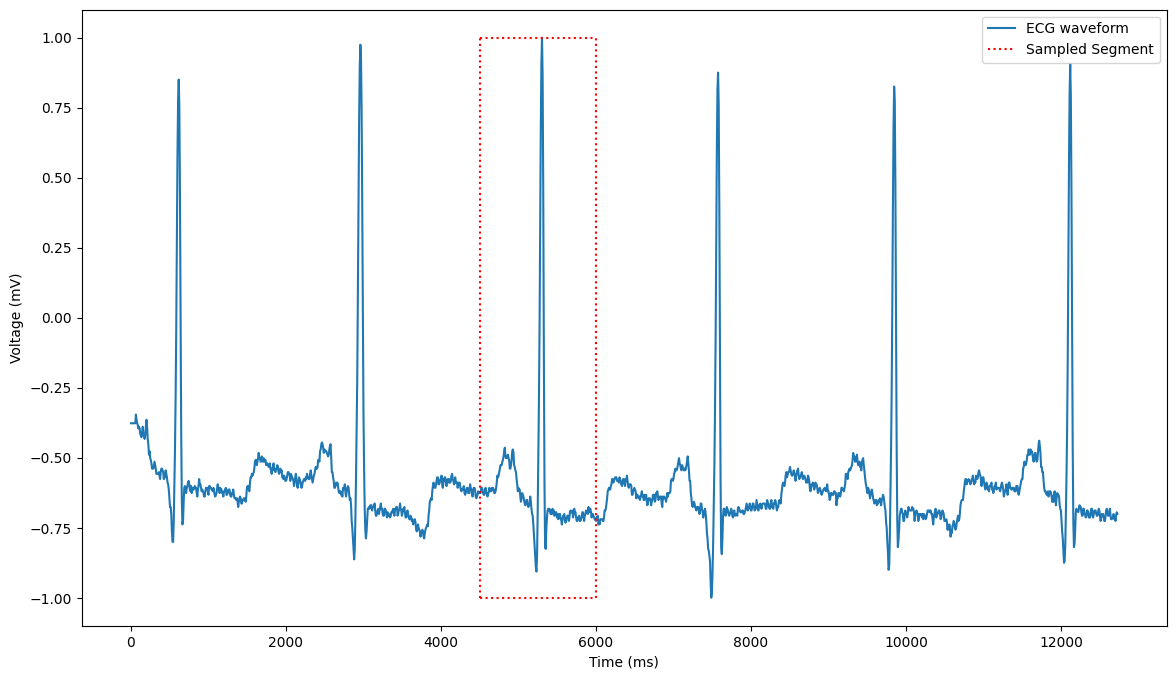

In [5]:

import matplotlib.pyplot as plt

sampling_freq = 125
num_samples = len(X_forecast)
time_ms = np.arange(num_samples) / sampling_freq * 1000

# Plot the ECG waveform
plt.figure(figsize=(14, 8))
plt.plot(time_ms, X_forecast, label='ECG waveform')

# Calculate box width in ms
box_width = 187 * 1000 / sampling_freq
start_x = 4500

# Plot the box
plt.plot([start_x, start_x + box_width], [min(X_forecast), min(X_forecast)], linestyle=':', color='red', label="Sampled Segment")
plt.plot([start_x, start_x + box_width], [max(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x, start_x], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')
plt.plot([start_x + box_width, start_x + box_width], [min(X_forecast), max(X_forecast)], linestyle=':', color='red')

plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

## 4. Visualising Genetic Oscillators
In order to understand how our reservoir will operate, we can use a sine wave to test the forward function of a single Oscillator node.

### 4.1 Collecting Oscillator States
We can simulate the behaviour of gene expression using our Oscillator node by feeding in a continuous input of a sine wave over a period of 1000 timesteps.

For each call of the Oscillator's `forward` function, we receive an array of system states of shape (1, 4), where we have a single state for each variable in the system (A, I, Hi, He).

We can collect these states over the time series to understand the influence of our input to the system.

In [6]:
from reservoir.node import Oscillator

timesteps = 1000
coupling = 1e-5

timespan = np.linspace(0, timesteps, timesteps)
sine_wave = np.sin(timespan)

oscillator = Oscillator(timesteps=timesteps)

states = []
for i in range(timesteps):
    states.append(oscillator.forward(sine_wave[i] * coupling))

states = np.array(states)

KeyError: 'delay'

### 4.2 Visualising Genetic Oscillator States
We can now visualise the states of the coupled genes (A, I), as well as the internal and external signals (Hi, He) over the time period.

We can see the synchronized coupled oscillations by genes A and I, where the delayed He signal drives the production of the I gene promoter.

In [ ]:
from utils.visualisation import plot_states

print("Oscillator States Shape: ", states.shape)
plot_states(states, labels=["A", "I", "Hi", "He"], ylabel="Concentration", title="", legend=True, show=True)

## 5. Constructing an Echo State Network
Here we will initialize our reservoir and readout nodes, two key layers within an echo-state network, the final layer is the input layer, however we will be omitting the use of a physical input node for our model as we feed the input to the reservoir by hand.

### 5.1 Initializing the Reservoir
To initialize our reservoir we must supply a range of important hyperparameters:
- `timesteps` the timespan of each data instance, allows the Oscillator nodes to know when to reset their internal history.
- `nodes` the number of Oscillator nodes within the reservoir.
- `delay` the time delay of the external He signal within the genetic oscillators.
- `initial_conditions` the intial concentrations of each molecule in the genetic oscillators (A, I, Hi, He)

We construct a dictionary using the `delay` and `initial_conditions` parameters to pass to the `OscillatorReservoir` as the `node_kwargs` parameter. This is because the reservoir will propagate the parameters directly through to the Oscillator nodes as `kwargs`.

Note, there are further hyper-parameters of the reservoir but for now we will focus on these as they are integral to our system producing oscillations.

In [ ]:
from reservoir.reservoir import OscillatorReservoir

timesteps = X_train[0].shape[0]
print("Timesteps: ", timesteps)

nodes = 50
delay = 10
initial_conditions = [0, 100, 0, 0]

node_kwargs = {'delay': delay, 'initial_conditions': initial_conditions}

reservoir = OscillatorReservoir(
    units=nodes,
    timesteps=timesteps,
    node_kwargs=node_kwargs,
    seed=SEED)

print("Reservoir Hyperparameters: ", reservoir.hypers)

### 5.2 Initializing our Readout Node
We will be using a reservoirpy `Ridge` node as our readout node which employs a layer of `N` neurons, where `N` is the number of classes in our task, each Ridge neuron uses regularized Tikhonov linear regression to perform learning.

In [ ]:
from reservoirpy.nodes import Ridge

ridge = 1e-5
readout = Ridge(ridge=1e-5)

print("Ridge Hyperparameters: ", readout.hypers)

### 5.3 Visualising Reservoir States
We can visualise the activation of our reservoir by plotting the states produced by our reservoir for the timeseries of a single instance of data.
Here we can understand how our network of genetic oscillators perform in unison.

In [ ]:

states = reservoir.run(X_train[0])
print("Reservoir States Shape: ", states.shape)

plot_states(states, legend=False)  # disable legend to not pollute the figure with node labels

## 6. Analysing our Classification Dataset
In this section, we visualize various aspects of our dataset using functions from the `utils.visualisation` module.

### 6.1 Concatenating Training and Test Subsets

Before visualization, we concatenate the training and test subsets of our dataset into a single dataset, of targets `X` and labels `Y`.

In [ ]:
# concatenate the training and test subsets into one
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

### 6.2 Plotting Dataset Information
We use the `plot_data_distribution` function to visualize the distribution of classes in our dataset and save the plot as "data-distribution.png".

In [ ]:
from utils.visualisation import plot_data_distribution

plot_data_distribution(Y, filename="data-distribution.png", show=True)

Next, we use the plot_dataset_info function to visualize various statistics and information about our dataset, such as the number of instances per class, mean, and standard deviation.

In [ ]:
from utils.visualisation import plot_dataset_info

plot_dataset_info(X_train, Y_train, X_test, Y_test, filename="dataset-info.png", show=True)

### 6.3 Plotting Standard Deviation and Mean Across Classes
We further visualize the class standard deviation, and class mean using the corresponding functions.

In [ ]:
from utils.visualisation import plot_class_std
from utils.visualisation import plot_class_mean

plot_class_std(X, Y, filename="class-std.png", show=True)
plot_class_mean(X, Y, filename="class-means.png", show=True)

### 6.4 Visualising Class Averages
Next, we can visualise the average of each class with a single representative waveform which represents the mean of each time point within each class.

In [ ]:
from utils.visualisation import plot_average_instance

plot_average_instance(X, Y, filename="average-instance.png", show=True)

## 7. Classification

With our classification dataset loaded and our echo state network (ESN) layers constructed, we're ready to perform classification.

Performing classification using our genetic oscillator reservoir is computationally intensive due to the amount of computation required to solve our system of delay differential equations, particularly because the reservoir forward function needs to run for each time step of each instance for every node in the reservoir.

- For instance, using a reservoir of 50 nodes and 1000 instances, the training process may take approximately 1 hour.

### 7.1 Multi-processed K-Fold Cross Validation

To ensure robustness and efficiency, we utilize cross-validation to average our model performance metrics over k-folds. Additionally, we leverage multi-processing, allocating each fold to a new CPU core. This setup allows each fold to run independently with its copies of the reservoir and readout nodes.

In [ ]:
# tag to indicate if file contains binary classification metrics
binary_tag = "-binary" if binary else ""

# filename to save classification metrics to
filename = f"results/runs/{reservoir.name}-{nodes}-{len(X_train)}{binary_tag}"

In [ ]:
from utils.classification import classify

folds = 5

metrics = classify(reservoir=reservoir, 
                   readout=readout, 
                   X_train=X_train, 
                   Y_train=Y_train, 
                   X_test=X_test, 
                   Y_test=Y_test, 
                   folds=folds, 
                   save_file=filename)


# 8. Plotting Performance Metrics
Once classification is complete, we can plot the resulting metrics to understand how our model performed.

We load the data which the `classify` function has just saved to our local `results/runs` directory which contains the performance metrics, model hyperparameters, and predicted labels.

In [ ]:
from utils.preprocessing import load_npz

folds_data = []

for fold in range(folds):
    fold_filename = filename + f"-fold-{str(fold)}.npz"
    fold_data = load_npz(fold_filename, allow_pickle=True)
    folds_data.append(fold_data)

### 8.1 Plotting Deviation Between Folds
We can plot the difference of the metrics per fold, visualising how shuffling the dataset effects the model.
    - We should see high-similarity between folds which indicates that our model has not overfitted.

In [ ]:
from utils.visualisation import plot_metrics_across_folds

folds_metrics = []

for fold in folds:
    metrics = fold_data[fold]['metrics'].item()
    folds_metrics.append(metrics)

plot_metrics_across_folds(folds_metrics)

### 8.2 Compute Mean Metrics Across Folds
Finally, we can plot the metrics of our classification task, using the mean of each metric across the cross validation folds.

But first we need to find the mean of the metrics across the folds using our `folds_metrics` list.

In [ ]:
from utils.analysis import compute_mean_metrics, log_metrics

metrics = compute_mean_metrics(folds_metrics)

log_metrics(metrics)

### 8.3 Plotting Metrics By Class
Next, we can plot the precision, recall, and F1 score of each class, indicating the model's ability to predict each class individually.

In [ ]:
from utils.visualisation import plot_class_metrics

plot_class_metrics(metrics['class_metrics'])

### 8.4 Plotting Confusion Matrix
We can also plot the confusion matrix, which visualises the true labels against the model's predictions:

In [ ]:
from utils.visualisation import plot_confusion_matrix

plot_confusion_matrix(metrics['confusion_matrix'])

### 8.5 Plotting Clustering of Predictions
Finally, we can plot the t-SNE clustering of our model's predictions which visualises the underlying non-linear relationships between predictions by class.

In [ ]:
from utils.visualisation import plot_tsne_clustering
import numpy as np

# concatenate the predictions across the folds
Y_pred = []
for fold in range(folds):
    Y_pred.append(folds_data[fold]['Y_pred'])

Y_pred = np.concatenate(Y_pred)

plot_tsne_clustering(Y_pred, show=True)

## 9. Forecasting
Forecasting is a significant feature of reservoir computing, however we have been unable to optimize our Oscillator Reservoir for forecasting and therefore we will demonstrate using reservoirpy's `Reservoir` node to showcase the potential.

### 9.1 Loading our ECG Forecasting Dataset

In [ ]:
from utils.preprocessing import load_ecg_forecast, load_mackey_glass


timesteps = 2500
forecast_steps = 10
test_ratio = 0.1

# load forecasting dataset, where the test set is "forecast" timesteps ahead of the training test set
X_train, Y_train, X_test, Y_test = load_ecg_forecast(
    timesteps=timesteps, 
    forecast=forecast_steps, 
    test_ratio=test_ratio)

# X_train, Y_train, X_test, Y_test = load_mackey_glass()


### 9.2 Visualizing our Forecasting Dataset

In [ ]:
from utils.visualisation import  plot_forecast_data

plot_forecast_data(X_train, Y_train, X_test, Y_test)

### 9.3 Initializing the Reservoir and Readout

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge

SEED = 1337

nodes = 100
leak_rate = 0.1
sr = 1.0
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.1

reservoir = Reservoir(
    units=nodes,
    sr=sr,
    input_scaling=input_scaling,
    input_connectivity=input_connectivity,
    seed=SEED)

ridge = 1e-7
readout = Ridge(ridge=ridge)


### 9.4 Perform Forecasting

In [ ]:
import numpy as np

# Construct echo-state network model
esn = reservoir >> readout

# Fit ESN and train
esn.fit(X_train, Y_train)

Y_pred = esn.run(X_test)

# Compute Loss Metrics (Mean Squared Error & Root Mean Squared Error)
mse = np.mean((Y_test - Y_pred) ** 2)
rmse = np.sqrt(mse)

print("MSE: ", mse)
print("RMSE: ", rmse)


### 9.5 Plot Forecasting Results

In [ ]:
from utils.visualisation import plot_forecast_results

plot_forecast_results(Y_pred, Y_test, sample=len(Y_pred))